**1. IMPORTANT LIBRARIES**

In [1]:
import torch 
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import CIFAR10
import torch.optim as optim

/home/toluwani/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**2. LOADING & USING PYTORCH TRANSFORMS ON CIFAR10**

In [2]:
#augmentations and transforms to be used on the train and test sets
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

#applying the transforms to the train-test set
train_ds = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_ds = CIFAR10(root='./data', train=False, download=True, transform=transform)

#creating the train and test loaders from their respective sets
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


**3. CODING THE LENET-5 AND ALEXNET ARCHITECTURES**

In [3]:
class LeNet(nn.Sequential):
    def __init__(self, img_channels=3, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class AlexNet(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels= 96, kernel_size= 3, stride=1, padding=0 )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride= 1, padding= 1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**4. SETTING UP GPU AND CRITERION**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to train on GPU, else CPU
criterion = nn.CrossEntropyLoss()

**5. DEFINING THE TRAIN AND TEST FUNCTION**

In [5]:
def train_test(model, train_loader, test_loader, optimizer, n_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to train on GPU, else CPU
    # model in training mode
    model.train()
    train_l = []
    for epoch in range(1, n_epochs+1):
        train_accuracy = 0
        train_samples = 0
        train_loss = 0.0
        for data, targets in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(output, dim=-1)
            train_samples += predictions.size(0)
            train_accuracy += (predictions == targets).sum()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)
        train_l.append(train_loss)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

        test_acc = []
        with torch.no_grad():
            model.eval()
            test_loss = 0
            test_accuracy = 0
            test_samples = 0
            for data,targets in test_loader:
                data = data.to(device=device)
                targets = targets.to(device=device)
                ## Forward Pass
                scores = model(data)
                loss = criterion(scores,targets)
                predictions = torch.argmax(scores, dim=-1)
                test_accuracy += (predictions == targets).sum()
                test_samples += predictions.size(0)
                test_loss += loss.item()
            t_a = (test_accuracy / test_samples)*100
            test_acc.append(t_a)
            print(f"Test Accuracy: {t_a:.3f}") 
    return model, train_l, test_acc

**5(A). TRAINING LENET WITH SGD**

In [6]:
lenet = LeNet().to(device)
sgd_lenet = optim.SGD(lenet.parameters(), lr=1e-3) #SGD
lenet_sgd, loss_sgd, acc_sgd = train_test(lenet, train_dl, test_dl, sgd_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 2.302662
Test Accuracy: 9.960
Epoch: 2 	Training Loss: 2.301677
Test Accuracy: 11.030
Epoch: 3 	Training Loss: 2.300317
Test Accuracy: 13.350
Epoch: 4 	Training Loss: 2.297900
Test Accuracy: 16.720
Epoch: 5 	Training Loss: 2.292468
Test Accuracy: 15.600
Epoch: 6 	Training Loss: 2.276850
Test Accuracy: 13.990
Epoch: 7 	Training Loss: 2.243588
Test Accuracy: 17.860
Epoch: 8 	Training Loss: 2.205465
Test Accuracy: 21.360
Epoch: 9 	Training Loss: 2.165790
Test Accuracy: 25.480
Epoch: 10 	Training Loss: 2.126352
Test Accuracy: 25.520
Epoch: 11 	Training Loss: 2.084967
Test Accuracy: 26.970
Epoch: 12 	Training Loss: 2.035487
Test Accuracy: 28.570
Epoch: 13 	Training Loss: 1.980897
Test Accuracy: 30.650
Epoch: 14 	Training Loss: 1.936250
Test Accuracy: 32.190
Epoch: 15 	Training Loss: 1.901042
Test Accuracy: 32.680
Epoch: 16 	Training Loss: 1.870411
Test Accuracy: 34.410
Epoch: 17 	Training Loss: 1.840549
Test Accuracy: 35.400
Epoch: 18 	Training Loss: 1.808490
Test A

**5(B). TRAINING LENET WITH SGD+MOMENTUM**

In [7]:
lenet = LeNet().to(device)
sgdm_lenet = optim.SGD(lenet.parameters(), lr=1e-3, momentum=0.9) #SGD with momentum
lenet_sgdm, loss_sgdm, acc_sgdm = train_test(lenet, train_dl, test_dl, sgdm_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 2.275044
Test Accuracy: 24.660
Epoch: 2 	Training Loss: 1.915141
Test Accuracy: 37.270
Epoch: 3 	Training Loss: 1.638493
Test Accuracy: 43.450
Epoch: 4 	Training Loss: 1.483431
Test Accuracy: 47.670
Epoch: 5 	Training Loss: 1.402135
Test Accuracy: 51.040
Epoch: 6 	Training Loss: 1.332108
Test Accuracy: 53.140
Epoch: 7 	Training Loss: 1.274037
Test Accuracy: 54.520
Epoch: 8 	Training Loss: 1.223176
Test Accuracy: 56.460
Epoch: 9 	Training Loss: 1.180314
Test Accuracy: 57.680
Epoch: 10 	Training Loss: 1.141949
Test Accuracy: 58.640
Epoch: 11 	Training Loss: 1.108482
Test Accuracy: 60.370
Epoch: 12 	Training Loss: 1.073304
Test Accuracy: 62.230
Epoch: 13 	Training Loss: 1.046016
Test Accuracy: 62.060
Epoch: 14 	Training Loss: 1.022788
Test Accuracy: 61.530
Epoch: 15 	Training Loss: 0.999831
Test Accuracy: 62.640
Epoch: 16 	Training Loss: 0.974984
Test Accuracy: 63.590
Epoch: 17 	Training Loss: 0.958476
Test Accuracy: 64.170
Epoch: 18 	Training Loss: 0.935733
Test 

**5(C). TRAINING LENET WITH ADAGRAD**

In [8]:
lenet = LeNet().to(device)
ag_lenet = optim.Adagrad(lenet.parameters(), lr=1e-3) #Adagrad
lenet_ag, loss_ag, acc_ag = train_test(lenet, train_dl, test_dl, ag_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 1.945888
Test Accuracy: 33.340
Epoch: 2 	Training Loss: 1.824652
Test Accuracy: 35.500
Epoch: 3 	Training Loss: 1.774434
Test Accuracy: 36.910
Epoch: 4 	Training Loss: 1.736010
Test Accuracy: 38.300
Epoch: 5 	Training Loss: 1.705845
Test Accuracy: 38.880
Epoch: 6 	Training Loss: 1.680451
Test Accuracy: 39.900
Epoch: 7 	Training Loss: 1.659240
Test Accuracy: 40.650
Epoch: 8 	Training Loss: 1.641373
Test Accuracy: 40.900
Epoch: 9 	Training Loss: 1.624340
Test Accuracy: 41.700
Epoch: 10 	Training Loss: 1.610433
Test Accuracy: 41.970
Epoch: 11 	Training Loss: 1.599010
Test Accuracy: 42.530
Epoch: 12 	Training Loss: 1.587490
Test Accuracy: 42.760
Epoch: 13 	Training Loss: 1.578230
Test Accuracy: 42.850
Epoch: 14 	Training Loss: 1.568048
Test Accuracy: 43.760
Epoch: 15 	Training Loss: 1.562270
Test Accuracy: 44.050
Epoch: 16 	Training Loss: 1.552911
Test Accuracy: 44.200
Epoch: 17 	Training Loss: 1.545234
Test Accuracy: 44.310
Epoch: 18 	Training Loss: 1.538684
Test 

**5(D). TRAINING LENET WITH RMSPROP**

In [9]:
lenet = LeNet().to(device)
rms_lenet = optim.RMSprop(lenet.parameters(), lr=1e-3) #RMSprop
lenet_rms, loss_rms, acc_rms = train_test(lenet, train_dl, test_dl, rms_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 1.580341
Test Accuracy: 49.750
Epoch: 2 	Training Loss: 1.321714
Test Accuracy: 54.290
Epoch: 3 	Training Loss: 1.214585
Test Accuracy: 58.270
Epoch: 4 	Training Loss: 1.140315
Test Accuracy: 60.780
Epoch: 5 	Training Loss: 1.082767
Test Accuracy: 61.930
Epoch: 6 	Training Loss: 1.043921
Test Accuracy: 60.070
Epoch: 7 	Training Loss: 1.010773
Test Accuracy: 63.610
Epoch: 8 	Training Loss: 0.976531
Test Accuracy: 62.990
Epoch: 9 	Training Loss: 0.951289
Test Accuracy: 63.430
Epoch: 10 	Training Loss: 0.926266
Test Accuracy: 63.840
Epoch: 11 	Training Loss: 0.909135
Test Accuracy: 63.510
Epoch: 12 	Training Loss: 0.891329
Test Accuracy: 64.070
Epoch: 13 	Training Loss: 0.880349
Test Accuracy: 63.900
Epoch: 14 	Training Loss: 0.860473
Test Accuracy: 65.340
Epoch: 15 	Training Loss: 0.847475
Test Accuracy: 62.900
Epoch: 16 	Training Loss: 0.835858
Test Accuracy: 64.990
Epoch: 17 	Training Loss: 0.817067
Test Accuracy: 63.630
Epoch: 18 	Training Loss: 0.810273
Test 

**5(E). TRAINING LENET WITH ADAM**

In [10]:
lenet = LeNet().to(device)
adam_lenet = optim.Adam(lenet.parameters(), lr=1e-3) #Adam
lenet_adam, loss_adam, acc_adam = train_test(lenet, train_dl, test_dl, adam_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 1.603750
Test Accuracy: 50.800
Epoch: 2 	Training Loss: 1.310200
Test Accuracy: 54.260
Epoch: 3 	Training Loss: 1.198932
Test Accuracy: 59.380
Epoch: 4 	Training Loss: 1.124416
Test Accuracy: 60.050
Epoch: 5 	Training Loss: 1.070921
Test Accuracy: 62.310
Epoch: 6 	Training Loss: 1.020648
Test Accuracy: 63.590
Epoch: 7 	Training Loss: 0.985738
Test Accuracy: 62.460
Epoch: 8 	Training Loss: 0.955624
Test Accuracy: 64.700
Epoch: 9 	Training Loss: 0.921235
Test Accuracy: 64.130
Epoch: 10 	Training Loss: 0.896626
Test Accuracy: 64.570
Epoch: 11 	Training Loss: 0.877237
Test Accuracy: 66.010
Epoch: 12 	Training Loss: 0.861596
Test Accuracy: 65.890
Epoch: 13 	Training Loss: 0.845258
Test Accuracy: 64.540
Epoch: 14 	Training Loss: 0.827916
Test Accuracy: 66.130
Epoch: 15 	Training Loss: 0.808603
Test Accuracy: 65.790
Epoch: 16 	Training Loss: 0.800759
Test Accuracy: 66.840
Epoch: 17 	Training Loss: 0.782855
Test Accuracy: 66.220
Epoch: 18 	Training Loss: 0.771706
Test 

**5(F). TRAINING ALEXNET WITH SGD**

In [11]:
alexnet = AlexNet().to(device)
sgd_alexnet = optim.SGD(alexnet.parameters(), lr=1e-3) #SGD
alexnet_sgd, a_loss_sgd, a_acc_sgd = train_test(alexnet, train_dl, test_dl, sgd_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 2.302507
Test Accuracy: 10.040
Epoch: 2 	Training Loss: 2.302268
Test Accuracy: 11.660
Epoch: 3 	Training Loss: 2.302011
Test Accuracy: 19.450
Epoch: 4 	Training Loss: 2.301700
Test Accuracy: 16.410
Epoch: 5 	Training Loss: 2.301288
Test Accuracy: 15.350
Epoch: 6 	Training Loss: 2.300695
Test Accuracy: 15.230
Epoch: 7 	Training Loss: 2.299758
Test Accuracy: 18.080
Epoch: 8 	Training Loss: 2.298127
Test Accuracy: 19.710
Epoch: 9 	Training Loss: 2.294870
Test Accuracy: 21.570
Epoch: 10 	Training Loss: 2.285994
Test Accuracy: 21.410
Epoch: 11 	Training Loss: 2.231183
Test Accuracy: 23.650
Epoch: 12 	Training Loss: 2.064181
Test Accuracy: 29.530
Epoch: 13 	Training Loss: 1.943910
Test Accuracy: 31.130
Epoch: 14 	Training Loss: 1.858402
Test Accuracy: 34.620
Epoch: 15 	Training Loss: 1.768393
Test Accuracy: 36.950
Epoch: 16 	Training Loss: 1.691709
Test Accuracy: 40.070
Epoch: 17 	Training Loss: 1.638838
Test Accuracy: 40.970
Epoch: 18 	Training Loss: 1.601778
Test 

**5(G). TRAINING ALEXNET WITH SGD+MOMENTUM**

In [12]:
alexnet = AlexNet().to(device)
sgdm_alexnet = optim.SGD(alexnet.parameters(), lr=1e-3, momentum=0.9) #SGD+momentum
alexnet_sgdm, a_loss_sgdm, a_acc_sgdm = train_test(alexnet, train_dl, test_dl, sgdm_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 2.299401
Test Accuracy: 24.440
Epoch: 2 	Training Loss: 1.890100
Test Accuracy: 39.040
Epoch: 3 	Training Loss: 1.517991
Test Accuracy: 46.750
Epoch: 4 	Training Loss: 1.370084
Test Accuracy: 53.070
Epoch: 5 	Training Loss: 1.252241
Test Accuracy: 57.320
Epoch: 6 	Training Loss: 1.144393
Test Accuracy: 62.070
Epoch: 7 	Training Loss: 1.030207
Test Accuracy: 66.090
Epoch: 8 	Training Loss: 0.928858
Test Accuracy: 67.860
Epoch: 9 	Training Loss: 0.834663
Test Accuracy: 71.380
Epoch: 10 	Training Loss: 0.747131
Test Accuracy: 73.540
Epoch: 11 	Training Loss: 0.670622
Test Accuracy: 73.470
Epoch: 12 	Training Loss: 0.603681
Test Accuracy: 77.490
Epoch: 13 	Training Loss: 0.544256
Test Accuracy: 75.730
Epoch: 14 	Training Loss: 0.493545
Test Accuracy: 78.370
Epoch: 15 	Training Loss: 0.433236
Test Accuracy: 78.350
Epoch: 16 	Training Loss: 0.386945
Test Accuracy: 80.050
Epoch: 17 	Training Loss: 0.334565
Test Accuracy: 79.820
Epoch: 18 	Training Loss: 0.287651
Test 

**5(H). TRAINING ALEXNET WITH ADAGRAD**

In [13]:
alexnet = AlexNet().to(device)
ag_alexnet = optim.Adagrad(alexnet.parameters(), lr=1e-3) #adagrad
alexnet_ag, a_loss_ag, a_acc_ag = train_test(alexnet, train_dl, test_dl, ag_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 1.435185
Test Accuracy: 59.320
Epoch: 2 	Training Loss: 1.010771
Test Accuracy: 66.350
Epoch: 3 	Training Loss: 0.846341
Test Accuracy: 70.040
Epoch: 4 	Training Loss: 0.741455
Test Accuracy: 74.910
Epoch: 5 	Training Loss: 0.665805
Test Accuracy: 75.230
Epoch: 6 	Training Loss: 0.606879
Test Accuracy: 76.750
Epoch: 7 	Training Loss: 0.558486
Test Accuracy: 77.850
Epoch: 8 	Training Loss: 0.517649
Test Accuracy: 78.590
Epoch: 9 	Training Loss: 0.480661
Test Accuracy: 79.910
Epoch: 10 	Training Loss: 0.448434
Test Accuracy: 80.370
Epoch: 11 	Training Loss: 0.420792
Test Accuracy: 79.680
Epoch: 12 	Training Loss: 0.395068
Test Accuracy: 80.940
Epoch: 13 	Training Loss: 0.368078
Test Accuracy: 81.090
Epoch: 14 	Training Loss: 0.345364
Test Accuracy: 80.960
Epoch: 15 	Training Loss: 0.323004
Test Accuracy: 79.900
Epoch: 16 	Training Loss: 0.299652
Test Accuracy: 82.680
Epoch: 17 	Training Loss: 0.281417
Test Accuracy: 81.940
Epoch: 18 	Training Loss: 0.260199
Test 

**5(I). TRAINING ALEXNET WITH RMSPROP**

In [14]:
alexnet = AlexNet().to(device)
rms_alexnet = optim.RMSprop(alexnet.parameters(), lr=1e-3) #rmsprop
alexnet_rms, a_loss_rms, a_acc_rms = train_test(alexnet, train_dl, test_dl, rms_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 189.794975
Test Accuracy: 44.330
Epoch: 2 	Training Loss: 1.210230
Test Accuracy: 61.910
Epoch: 3 	Training Loss: 0.888632
Test Accuracy: 70.710
Epoch: 4 	Training Loss: 0.755241
Test Accuracy: 74.140
Epoch: 5 	Training Loss: 0.681165
Test Accuracy: 73.810
Epoch: 6 	Training Loss: 0.614819
Test Accuracy: 72.070
Epoch: 7 	Training Loss: 0.573376
Test Accuracy: 74.630
Epoch: 8 	Training Loss: 0.536066
Test Accuracy: 77.830
Epoch: 9 	Training Loss: 0.507477
Test Accuracy: 76.730
Epoch: 10 	Training Loss: 0.486715
Test Accuracy: 76.830
Epoch: 11 	Training Loss: 0.461421
Test Accuracy: 76.350
Epoch: 12 	Training Loss: 0.448829
Test Accuracy: 78.860
Epoch: 13 	Training Loss: 0.434223
Test Accuracy: 77.280
Epoch: 14 	Training Loss: 0.423981
Test Accuracy: 78.300
Epoch: 15 	Training Loss: 0.408822
Test Accuracy: 77.790
Epoch: 16 	Training Loss: 0.400866
Test Accuracy: 78.620
Epoch: 17 	Training Loss: 0.500559
Test Accuracy: 80.200
Epoch: 18 	Training Loss: 0.495267
Tes

**5(J). TRAINING ALEXNET WITH ADAM**

In [15]:
alexnet = AlexNet().to(device)
adam_alexnet = optim.Adam(alexnet.parameters(), lr=1e-3) #Adam
alexnet_adam, a_loss_adam, a_acc_adam = train_test(alexnet, train_dl, test_dl, adam_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 1.616946
Test Accuracy: 53.620
Epoch: 2 	Training Loss: 1.160435
Test Accuracy: 63.250
Epoch: 3 	Training Loss: 0.985682
Test Accuracy: 67.820
Epoch: 4 	Training Loss: 0.870541
Test Accuracy: 69.310
Epoch: 5 	Training Loss: 0.798638
Test Accuracy: 70.900
Epoch: 6 	Training Loss: 0.737176
Test Accuracy: 71.080
Epoch: 7 	Training Loss: 0.682238
Test Accuracy: 71.590
Epoch: 8 	Training Loss: 0.632387
Test Accuracy: 72.320
Epoch: 9 	Training Loss: 0.593246
Test Accuracy: 73.040
Epoch: 10 	Training Loss: 0.554304
Test Accuracy: 73.500
Epoch: 11 	Training Loss: 0.519010
Test Accuracy: 72.520
Epoch: 12 	Training Loss: 0.481024
Test Accuracy: 73.290
Epoch: 13 	Training Loss: 0.456798
Test Accuracy: 74.480
Epoch: 14 	Training Loss: 0.419912
Test Accuracy: 74.180
Epoch: 15 	Training Loss: 0.402211
Test Accuracy: 74.430
Epoch: 16 	Training Loss: 0.378413
Test Accuracy: 75.140
Epoch: 17 	Training Loss: 0.361173
Test Accuracy: 73.080
Epoch: 18 	Training Loss: 0.333454
Test 

In [23]:
alexnet = AlexNet().to(device)
adam_alexnet = optim.Adam(alexnet.parameters(), lr=1e-5) #Adam
alexnet_adam, a_loss_adam, a_acc_adam = train_test(alexnet, train_dl, test_dl, adam_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 1.702130
Test Accuracy: 44.950
Epoch: 2 	Training Loss: 1.396558
Test Accuracy: 52.350
Epoch: 3 	Training Loss: 1.264846
Test Accuracy: 56.750
Epoch: 4 	Training Loss: 1.163847
Test Accuracy: 60.700
Epoch: 5 	Training Loss: 1.075309
Test Accuracy: 62.800
Epoch: 6 	Training Loss: 0.998335
Test Accuracy: 65.210
Epoch: 7 	Training Loss: 0.927768
Test Accuracy: 66.170
Epoch: 8 	Training Loss: 0.871130
Test Accuracy: 68.980
Epoch: 9 	Training Loss: 0.819590
Test Accuracy: 68.880
Epoch: 10 	Training Loss: 0.772687
Test Accuracy: 70.440
Epoch: 11 	Training Loss: 0.726489
Test Accuracy: 73.240
Epoch: 12 	Training Loss: 0.684364
Test Accuracy: 72.910
Epoch: 13 	Training Loss: 0.641335
Test Accuracy: 74.760
Epoch: 14 	Training Loss: 0.599874
Test Accuracy: 76.030
Epoch: 15 	Training Loss: 0.562203
Test Accuracy: 75.620
Epoch: 16 	Training Loss: 0.523768
Test Accuracy: 76.250
Epoch: 17 	Training Loss: 0.490754
Test Accuracy: 76.630
Epoch: 18 	Training Loss: 0.457836
Test 

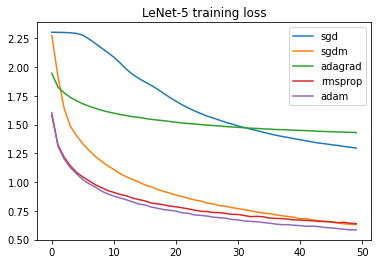

In [33]:
plt.plot(loss_sgd, label = "sgd")
plt.plot(loss_sgdm, label = "sgdm")
plt.plot(loss_ag, label = "adagrad")
plt.plot(loss_rms, label = "rmsprop")
plt.plot(loss_adam, label = "adam")
plt.legend(loc="upper right")
plt.title("LeNet-5 training loss")
plt.show()